# Assignment 5

Welcome to the assignment for week 5.

## Task 5: Optical Flow

### Task 5.1: Block Matching

* Implement the block matching method as shown in the lecture
* Take two frames from the datasets "lane_detection" or "copter_flight" with variable distances in time (1, 2, x) and compute the vector flow field
* Display a subset of flow vectors on the gray-value version of the first image, by drawing a respective line. adjust the grid density such that not too many vectors overlap (**RESULT**)

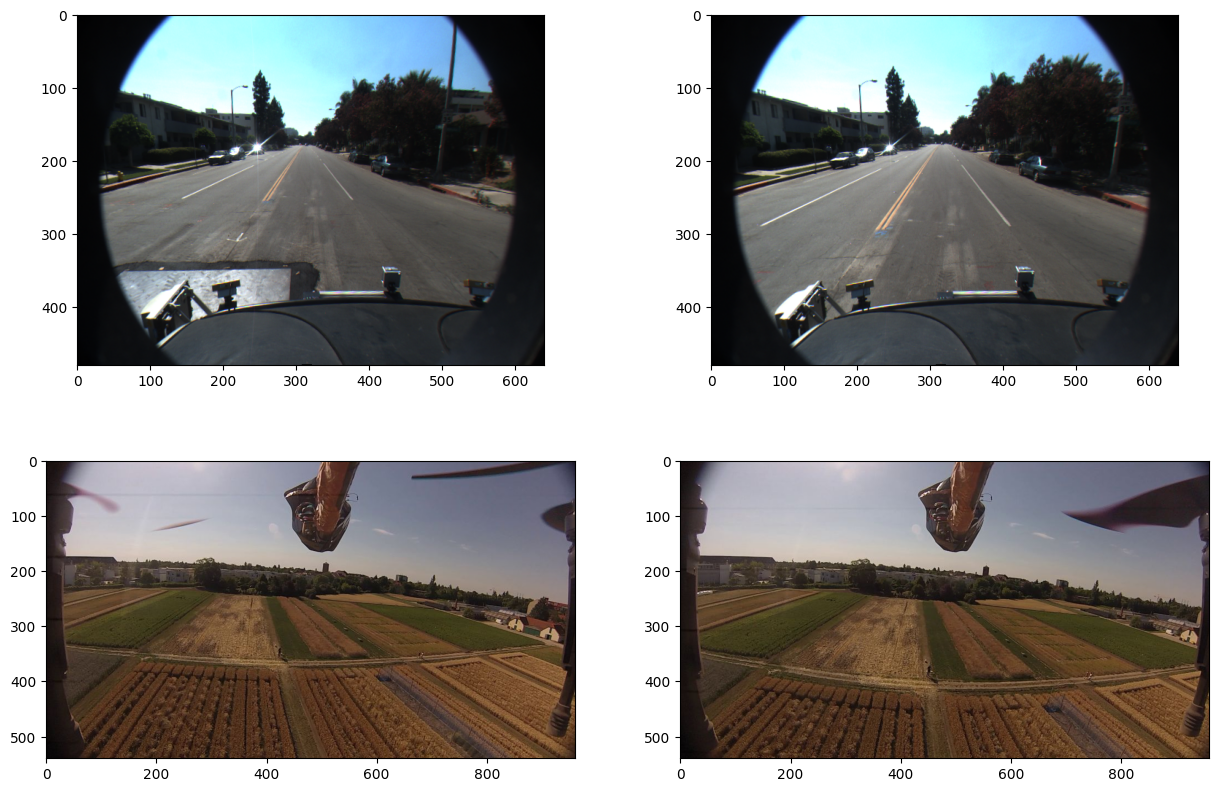

In [25]:
%matplotlib inline 
import matplotlib.pyplot as plt
from skimage import io, data, feature, color
import numpy as np
import matplotlib.patches as patches

# Chose other images if you like
lane1 = io.imread('images/lane_detection/f00000.png')
lane2 = io.imread('images/lane_detection/f00001.png')

copter1 = io.imread('images/copter_flight/frame050.jpg')
copter2 = io.imread('images/copter_flight/frame052.jpg')


fig = plt.figure(figsize=(15, 10))
ax11 = plt.subplot(2, 2, 1)
ax12 = plt.subplot(2, 2, 2)
ax21 = plt.subplot(2, 2, 3)
ax22 = plt.subplot(2, 2, 4)

ax11.imshow(lane1)
ax12.imshow(lane2)

ax21.imshow(copter1)
ax22.imshow(copter2)

In [26]:
# iterate over all delta x and delta y in window Wsearch around x,y
# compute sum of squared differences between image and image_next for there respective windows Wmatch
# store the flow vector for delta x and delta y for position x,y

def getSSD(img: np.array, img_diff: np.array) -> float:
    ssd = np.sum(np.square(img - img_diff))
    return ssd

def wrong_blockMatching(img: np.array, img_next: np.array, perf_mult: float = 1, grid_size: int = 1) -> np.array:
    img = img * perf_mult
    img_next = img_next * perf_mult
    height, width = img.shape
    WindowSize = 5
    flow = np.zeros((height, width, 2))
    for i in range(WindowSize, height - WindowSize, grid_size):
        for j in range(WindowSize, width - WindowSize, grid_size):
            Wsearch = img[i - WindowSize:i + WindowSize, j - WindowSize:j + WindowSize]
            minSSD = np.inf
            for k in range(WindowSize, height - WindowSize, grid_size):
                for l in range(WindowSize, width - WindowSize, grid_size):
                    Wmatch = img_next[k - WindowSize:k + WindowSize, l - WindowSize:l + WindowSize]
                    #print(f"i: {i}, j: {j}, k: {k}, l: {l}")
                    ssd = getSSD(Wsearch, Wmatch)
                    if ssd < minSSD:
                        minSSD = ssd
                        flow[i:i+grid_size, j:j+grid_size] = [k - i, l - j]
    return flow

def blockMatching(img: np.array, imgNext: np.array, searchBoundSize: int = 32, matchWindowSize: int = 8, searchGrid: int = 4, perfMult: float = 1) -> np.array:
    img = img * perfMult
    imgNext = imgNext * perfMult
    height, width = img.shape
    flow = np.zeros((height, width, 2))
    for i in range(matchWindowSize, height - matchWindowSize, searchGrid):
        for j in range(matchWindowSize, width - matchWindowSize, searchGrid):
            minSSD = np.inf
            imgMatch = img[i - matchWindowSize:i + matchWindowSize, j - matchWindowSize:j + matchWindowSize]
            # searching for matching window in next image in grid defined by searchGrid
            for k in range(np.max([matchWindowSize, i - searchBoundSize - matchWindowSize]), np.min([height - matchWindowSize, i + searchBoundSize - matchWindowSize]), searchGrid):
                for l in range(np.max([matchWindowSize, i - searchBoundSize - matchWindowSize]), np.min([width - matchWindowSize, i + searchBoundSize - matchWindowSize]), searchGrid):
                    imgNextMatch = imgNext[i - matchWindowSize:i + matchWindowSize, j - matchWindowSize:j + matchWindowSize]
                    ssd = getSSD(imgMatch, imgNextMatch)
                    # print(f"ssd {ssd} for i: {i}, j: {j}, k: {k}, l: {l}")
                    if ssd < minSSD:
                        minSSD = ssd
                        flow[i,j] = [k - i, j - l]
    return flow

In [27]:
#flow = wrong_blockMatching(color.rgb2gray(lane1), color.rgb2gray(lane2), 0.25, 20)
searchGrid = 8
flow = blockMatching(color.rgb2gray(lane1), color.rgb2gray(lane2), searchBoundSize=32, searchGrid=searchGrid, perfMult=1)


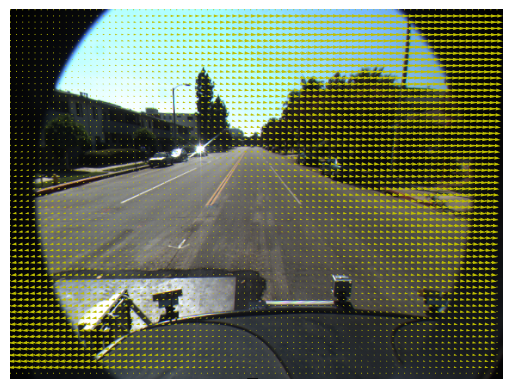

In [28]:
# plot flow field over first image

fig, ax = plt.subplots()
ax.quiver(np.arange(0, flow.shape[1], searchGrid), np.arange(0, flow.shape[0], searchGrid), flow[::searchGrid, ::searchGrid, 1], flow[::searchGrid, ::searchGrid, 0], color='y')
ax.axis('off')
ax.imshow(lane1)
plt.show()

### Task 5.2: Harris Corner Detection

* Implement the Harris Corner Detector as discussed in the lecture
* Compute and Plot the Harris Corners for the the two images given at the top of this assignment (**RESULT**)

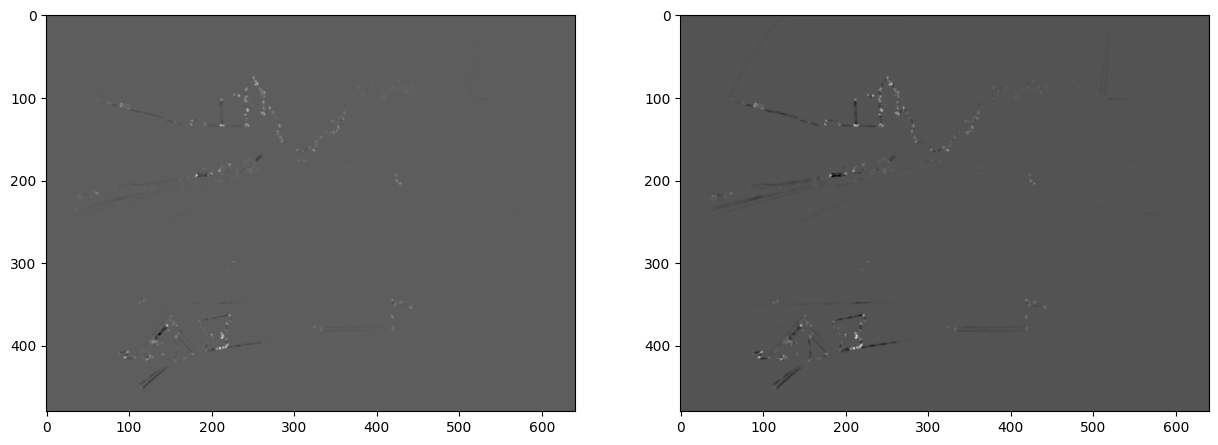

In [29]:
from skimage import filters

def getLocalMaximaOnGradient(img: np.array, orientation: int, windowSize: int) -> np.array:
    img = np.pad(img, windowSize, mode='constant')
    height, width = img.shape
    localMaxima = np.zeros_like(img)
    for i in range(windowSize, height - windowSize):
        for j in range(windowSize, width - windowSize):
            if orientation == 0:
                if img[i, j] > img[i, j - 1] and img[i, j] > img[i, j + 1]:
                    localMaxima[i, j] = 1
            elif orientation == 45:
                if img[i, j] > img[i - 1, j + 1] and img[i, j] > img[i + 1, j - 1]:
                    localMaxima[i, j] = 1
            elif orientation == 90:
                if img[i, j] > img[i - 1, j] and img[i, j] > img[i + 1, j]:
                    localMaxima[i, j] = 1
            elif orientation == 135:
                if img[i, j] > img[i - 1, j - 1] and img[i, j] > img[i + 1, j + 1]:
                    localMaxima[i, j] = 1
    return localMaxima

def getGaussianKernel(sigma: float, windowSize: int) -> np.array:
    kernel = np.zeros((windowSize, windowSize))
    for i in range(windowSize):
        for j in range(windowSize):
            kernel[i, j] = np.exp(-((i - windowSize // 2) ** 2 + (j - windowSize // 2) ** 2) / (2 * sigma ** 2))
    return kernel / np.sum(kernel)

def getHarrisCornerDetection(img: np.array) -> np.array:
    img_x_derivative = np.gradient(img, axis=0)
    img_y_derivative = np.gradient(img, axis=1)

    # product of derivatives
    img_x2 = img_x_derivative * img_x_derivative
    img_y2 = img_y_derivative * img_y_derivative
    img_xy = img_x_derivative * img_y_derivative

    # sum of products of derivatives with gaussian filter
    img_x2 = filters.gaussian(img_x2, sigma=1)
    img_y2 = filters.gaussian(img_y2, sigma=1)
    img_xy = filters.gaussian(img_xy, sigma=1)

    # auto-correlation matrix A
    A = np.zeros((img.shape[0], img.shape[1], 2, 2))
    A[:,:,0,0] = img_x2
    A[:,:,0,1] = img_xy
    A[:,:,1,0] = img_xy
    A[:,:,1,1] = img_y2
    
    # threshold for R
    k = 0.05
    R = np.zeros_like(img)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            R[i, j] = np.linalg.det(A[i, j]) - k * np.square(np.trace(A[i, j]))

    #compute non-maximum suppression

    # orientation of gradients and round to neighbor 45°
    # img_orientation = np.arctan2(img_y_derivative, img_x_derivative)
    # img_orientation = np.rad2deg(img_orientation)
    # img_orientation = np.round(img_orientation / 45) * 45 % 180

    # # get local maxima for each orientation
    # R = getLocalMaximaOnGradient(R, 0, 1) + getLocalMaximaOnGradient(R, 45, 1) + getLocalMaximaOnGradient(R, 90, 1) + getLocalMaximaOnGradient(R, 135, 1)

    return R

    # corners = np.zeros_like(R)
    # for i in range(1, R.shape[0] - 1):
    #     for j in range(1, R.shape[1] - 1):
    #         if R[i, j] > R[i-1, j-1] and R[i, j] > R[i-1, j] and R[i, j] > R[i-1, j+1] and R[i, j] > R[i, j-1] and R[i, j] > R[i, j+1] and R[i, j] > R[i+1, j-1] and R[i, j] > R[i+1, j] and R[i, j] > R[i+1, j+1]:
    #             corners[i, j] = 1
    # return corners

corners = getHarrisCornerDetection(color.rgb2gray(lane1))
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
axs[0].imshow(corners, cmap='gray')
axs[1].imshow(feature.corner_harris(color.rgb2gray(lane1)), cmap='gray')
    

### Task 5.3: Lucas Kanade

* For the corner images from Task 5.2, track them with Lucas Kanade (feel free to use e.g. the function "calcOpticalFlowPyrLK" in OpenCV)
* Mark the positions of your Harris Corners and draw the flow vectors found by Lucas-Kanade on the gray-value versions of the two images given in the beginning of this assignment (**RESULT**)


In [37]:
import cv2 as cv
import argparse

def getLucasKanadeOF(img: np.array, img_next: np.array):
    lk_params = dict(
        winSize=(15, 15),
        maxLevel=2,
        criteria=(cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03)
    )

    # color = np.random.randint(0, 255, (100, 3))
    corners = getHarrisCornerDetection(color.rgb2gray(img))

    p0 = np.argwhere(corners > 0).astype(np.float32)
    p0 = p0.reshape(-1, 1, 2)
    print(f"p0 Shape: {p0.shape}")
    p1, st, err = cv.calcOpticalFlowPyrLK(img, img_next, p0, None, **lk_params)

    print(f"p1 Shape: {p1.shape}")
    if p1 is not None:
        good_new = p1[st == 1]
    
    for i, (new, old) in enumerate(zip(good_new, p0)):
        a, b = new.ravel()
        c, d = old.ravel()
        img = cv.line(img, (int(c), int(d)), (int(a), int(b)), (0, 255, 0), 2)
        img = cv.circle(img, (int(a), int(b)), 5, (0, 0, 255), -1)

    cv.imshow('frame', img)

getLucasKanadeOF(lane1, lane2)

p0 Shape: (113515, 1, 2)
p1 Shape: (113515, 1, 2)


## Congratz, you made it! :)